In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
import itertools
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram


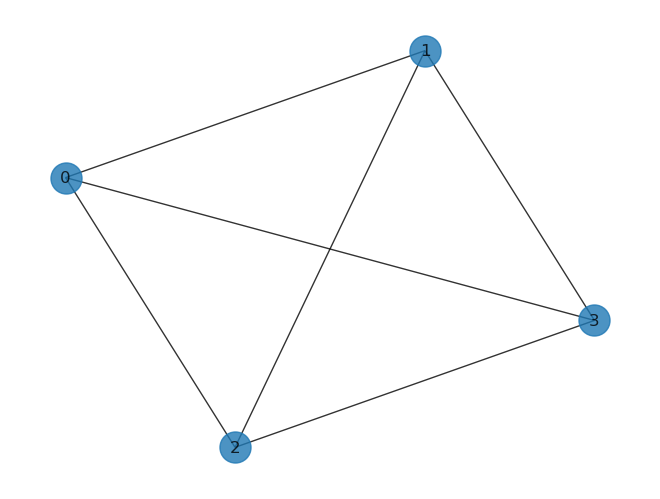

In [2]:
G = nx.Graph()
G.add_nodes_from(range(4))
G.add_edges_from(itertools.combinations(list(G.nodes), 2))
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

# Using Classical Optimizer to finetune parameters 

In [3]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

# Analyzing the result

## P = 2

In [4]:
expectation = get_expectation(G)

res = minimize(expectation, 
                      [1.0, 1.0, 1.0, 1.0], 
                      method='COBYLA')
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.9794921875
       x: [ 2.091e+00  7.989e-01  1.113e+00  8.931e-01]
    nfev: 50
   maxcv: 0.0

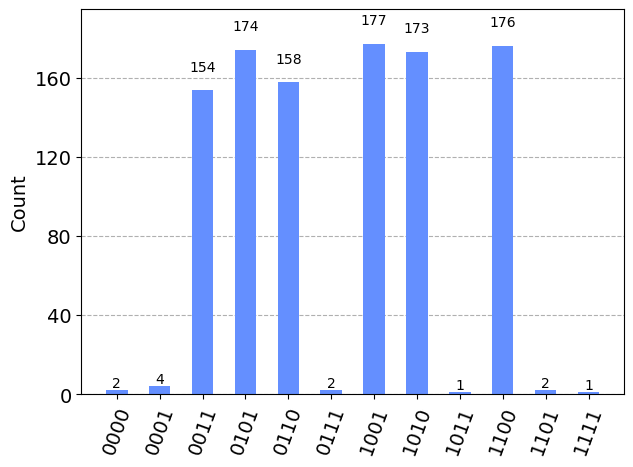

In [5]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

## P = 1

In [6]:
expectation = get_expectation(G)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.6923828125
       x: [ 2.739e-01 -2.564e-01]
    nfev: 32
   maxcv: 0.0

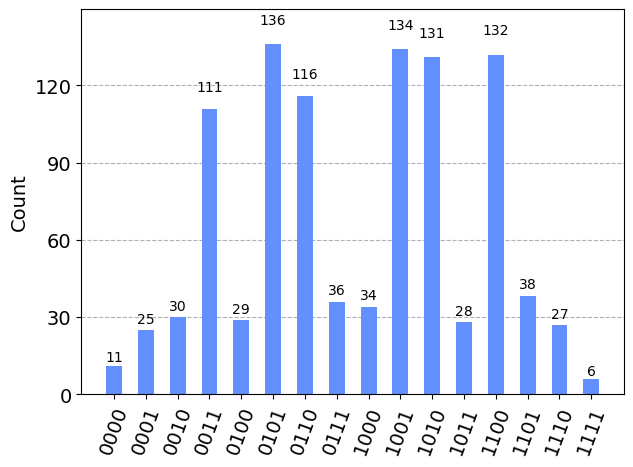

In [7]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

## P = 3

In [8]:
expectation = get_expectation(G)

res = minimize(expectation, 
                      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 
                      method='COBYLA')
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.9970703125
       x: [ 7.159e-01  1.142e-01  9.438e-01  1.071e+00  8.032e-01
            8.383e-01]
    nfev: 61
   maxcv: 0.0

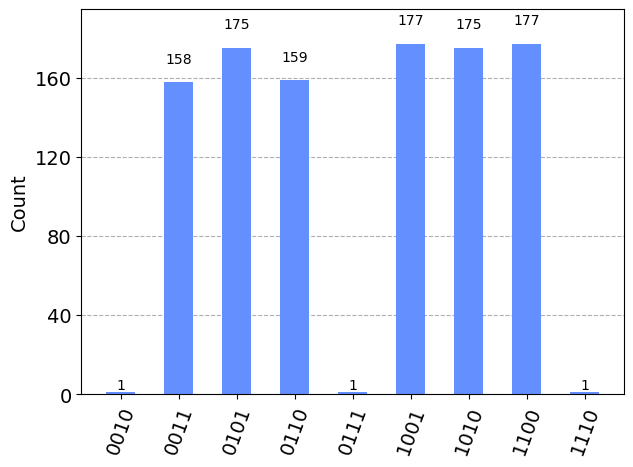

In [9]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)